In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,roc_curve
from scipy.stats import randint,uniform
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras.regularizers import l2


In [3]:
df=pd.read_csv(r"C:\Users\VICTUS\Downloads\The_Cancer_data_1500_V2.csv")
print(df.head(5))
print(df.info())
print(df.isnull().sum())

   Age  Gender        BMI  Smoking  GeneticRisk  PhysicalActivity  \
0   58       1  16.085313        0            1          8.146251   
1   71       0  30.828784        0            1          9.361630   
2   48       1  38.785084        0            2          5.135179   
3   34       0  30.040296        0            0          9.502792   
4   62       1  35.479721        0            0          5.356890   

   AlcoholIntake  CancerHistory  Diagnosis  
0       4.148219              1          1  
1       3.519683              0          0  
2       4.728368              0          1  
3       2.044636              0          0  
4       3.309849              0          1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1500 non-null   int64  
 1   Gender            1500 non-null   int64  
 2   BMI             

In [49]:
x = df.iloc[:, :-1].copy()
y = df['Diagnosis']

for col in df.iloc[:, :-1].columns:
    scaler = MinMaxScaler()
    x[col] = scaler.fit_transform(x[[col]])
x_dummies=pd.get_dummies(x,columns=['Gender'], dtype=float)

x_dummies.head(6)

,Age,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory,Gender_0.0,Gender_1.0
0,0.633333,0.043473,0.0,0.5,0.815020,0.831746,1.0,0.0,1.0
1,0.850000,0.634195,0.0,0.5,0.936653,0.705684,0.0,1.0,0.0
2,0.466667,0.952978,0.0,1.0,0.513678,0.948104,0.0,0.0,1.0
3,0.233333,0.602603,0.0,0.0,0.950780,0.409840,0.0,1.0,0.0
4,0.700000,0.820543,0.0,0.0,0.535866,0.663598,0.0,0.0,1.0
5,0.116667,0.885669,0.0,0.5,0.394257,0.465926,0.0,1.0,0.0


Best parameters: {'learning_rate': 0.03439097377334926, 'loss': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': 59, 'min_impurity_decrease': 0.17837938175535534, 'min_samples_leaf': 2, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.10266523373847858, 'n_estimators': 521, 'subsample': 0.6888888888888889}
Accuracy: 96.16666666666667 97.33333333333334


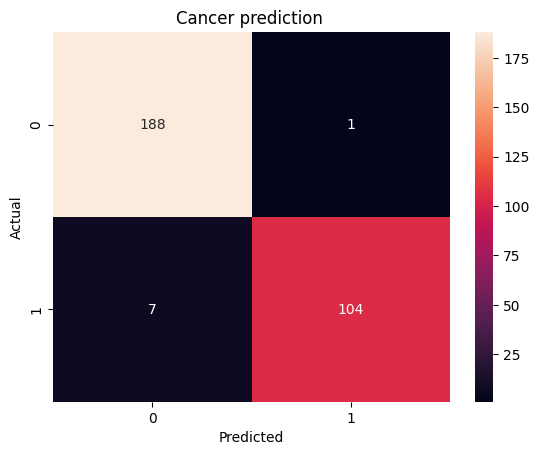

In [50]:




x_train, x_test, y_train, y_test = train_test_split(x_dummies, y, test_size=0.2, random_state=42, stratify=y)


gb = GradientBoostingClassifier(random_state=42)


param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    "subsample": np.linspace(0.6, 1.0, 10),
    'loss': ['log_loss', 'exponential'],
    'max_features': [ 'sqrt', 'log2',None],
    'min_weight_fraction_leaf': uniform(0.0,0.2) ,
    'min_impurity_decrease': uniform(0.0,0.2),
    'max_leaf_nodes': randint(10, 100),
   

}


random_search = RandomizedSearchCV(
    gb, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=10,  
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1  

)


random_search.fit(x_train, y_train)


best_model = random_search.best_estimator_


y_pred = best_model.predict(x_test)


print("Best parameters:", random_search.best_params_)
print("Accuracy:", best_model.score(x_train, y_train) * 100,best_model.score(x_test, y_test) * 100)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Cancer prediction ')
plt.show()

In [256]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x, y)

x_train1, x_test1, y_train1, y_test1 = train_test_split(
    x_res, y_res, test_size=0.2, random_state=42
)


In [277]:
model=Sequential([
    Dense(128,LeakyReLU(alpha=0.01),input_shape=(x_train1.shape[1],),kernel_regularizer=l2(0.001)),
    BatchNormalization(),
   Dropout(0.1),
    Dense(128,LeakyReLU(alpha=0.01),kernel_regularizer=l2(0.001)),
    BatchNormalization(),
   Dropout(0.1),
    Dense(64,LeakyReLU(alpha=0.01),kernel_regularizer=l2(0.001)),
    BatchNormalization(),
  Dropout(0.1),
    Dense(32,LeakyReLU(alpha=0.01),kernel_regularizer=l2(0.001)),
    BatchNormalization(),
  Dropout(0.1),
    Dense(1,activation='sigmoid')

])
optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001,weight_decay=0.0005)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

C:\Users\VICTUS\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\VICTUS\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [296]:
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=40,restore_best_weights=True),
     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)
]
history=model.fit(x_train1,y_train1,epochs=600,batch_size=32,validation_data=(x_test1,y_test1),callbacks=callbacks,verbose=1)

Epoch 1/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9410 - loss: 0.2770 - val_accuracy: 0.9418 - val_loss: 0.3570 - learning_rate: 1.0000e-05
Epoch 2/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9317 - loss: 0.2934 - val_accuracy: 0.9418 - val_loss: 0.3573 - learning_rate: 1.0000e-05
Epoch 3/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9324 - loss: 0.2824 - val_accuracy: 0.9418 - val_loss: 0.3582 - learning_rate: 1.0000e-05
Epoch 4/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9297 - loss: 0.2927 - val_accuracy: 0.9418 - val_loss: 0.3588 - learning_rate: 1.0000e-05
Epoch 5/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9257 - loss: 0.3147 - val_accuracy: 0.9418 - val_loss: 0.3588 - learning_rate: 1.0000e-05
Epoch 6/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9377 - loss: 0.2863 - val_accuracy: 0.9418 - val_loss: 0.3598 - learning_rate: 1.0000e-05
Epoch 7/600
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9271 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - loss: 0.3570 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


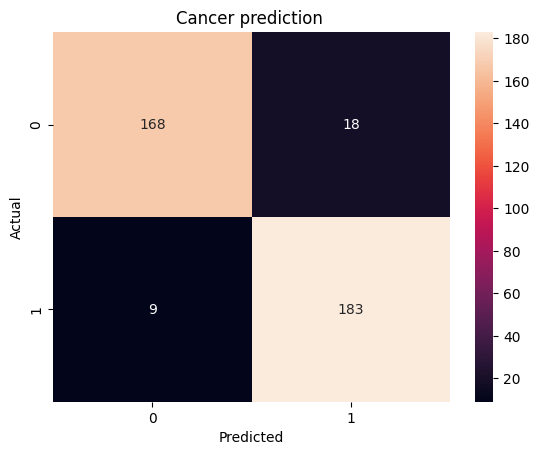

In [297]:
loss,accuracy=model.evaluate(x_test1,y_test1)

y_prob_ann = model.predict(x_test1)


y_pred_ann = (y_prob_ann > 0.30).astype(int)

cm = confusion_matrix(y_test1, y_pred_ann)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Cancer prediction ')
plt.show()

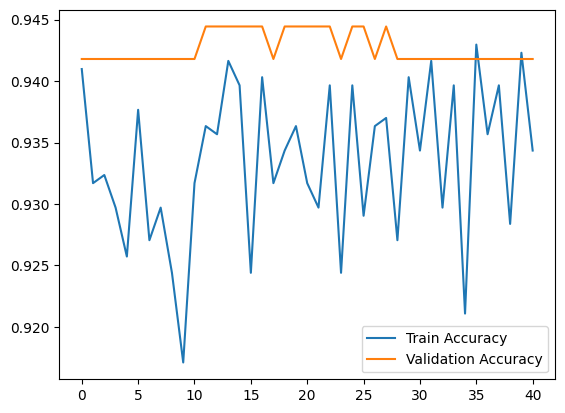

In [298]:
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()